# **📈 Stock Price Prediction using LSTM**
## **1️⃣ Introduction**
This notebook implements a **Long Short-Term Memory (LSTM)** model to predict Apple's (AAPL) stock prices. LSTMs are powerful deep learning models designed to capture sequential dependencies, making them suitable for time series forecasting.

### **📌 Key Steps in the Notebook:**
1. **Data Collection**: Fetch historical stock prices using `yfinance`.  
2. **Data Preprocessing**: Normalize and structure data for LSTM.  
3. **Model Development**: Build and train an optimized Bi-directional LSTM model.  
4. **Stock Price Prediction**: Forecast the next 30 days.  
5. **Visualization**: Compare actual vs predicted prices.

---

## **2️⃣ Data Collection & Preprocessing**
- Fetched **Apple's stock price data** from Yahoo Finance (`yfinance`).
- Retained only relevant columns: **Date, Open, High, Low, Close, Volume**.
- Scaled the **Close Price** using `MinMaxScaler` to improve LSTM performance.
- Split data into **Training (95%)** and **Testing (5%)** sets.

---

## **3️⃣ Model Architecture**
### **🔧 LSTM Model Details:**
- **Input:** Past **100 days of stock prices**.
- **Layers:**
  - **Bi-directional LSTM (128 units) + Dropout**
  - **Bi-directional LSTM (64 units) + Dropout**
  - **Dense (25 neurons, ReLU activation)**
  - **Dense (1 neuron for final prediction)**
- **Optimizer:** Nadam  
- **Loss Function:** Mean Squared Error (MSE)  
- **Regularization:** L1L2 to prevent overfitting  
- **Early Stopping:** Stops training if no improvement is observed.

---

## **4️⃣ Stock Price Prediction**
- Used **100 previous stock prices** to predict the next day.
- Forecasted **30 future days** using a rolling prediction approach.
- Rescaled predicted values back to original stock price range.

---

## **5️⃣ Results & Insights**
- **🔵 Historical Prices vs. 🔴 Forecasted Prices:**  
  - The model **successfully captured trends**, but short-term fluctuations were **underestimated**.
  - Forecasted prices were **too stable**, suggesting a need for improved volatility capture.
- **Key Improvements Suggested:**
  - **Increase sequence length** from **100 → 200 days** for better trend learning.
  - **Add randomness in predictions** to capture volatility.
  - **Refine MinMaxScaler usage** to avoid bias.

---

## **6️⃣ Conclusion**
- The **LSTM model effectively predicts stock price trends** but struggles with capturing volatility.
- Future improvements include **fine-tuning hyperparameters, incorporating external features (e.g., news sentiment), and experimenting with attention mechanisms** for better accuracy.
- This model **provides a solid foundation** for stock price forecasting and can be extended for portfolio analysis.


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import pickle




[*********************100%***********************]  1 of 1 completed


Price,Date,Open,High,Low,Close,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
3301,2025-02-19,244.660004,246.009995,243.160004,244.869995,32204200
3302,2025-02-20,244.940002,246.779999,244.289993,245.830002,32316900
3303,2025-02-21,245.949997,248.690002,245.220001,245.550003,53197400
3304,2025-02-24,244.929993,248.860001,244.419998,247.100006,51326400
3305,2025-02-25,248.000000,250.000000,244.910004,247.039993,48013300
3306,2025-02-26,244.330002,244.979996,239.130005,240.360001,44433600
3307,2025-02-27,239.410004,242.460007,237.059998,237.300003,41153600
3308,2025-02-28,236.949997,242.089996,230.199997,241.839996,56833400
3309,2025-03-03,241.789993,244.029999,236.110001,238.029999,47184000


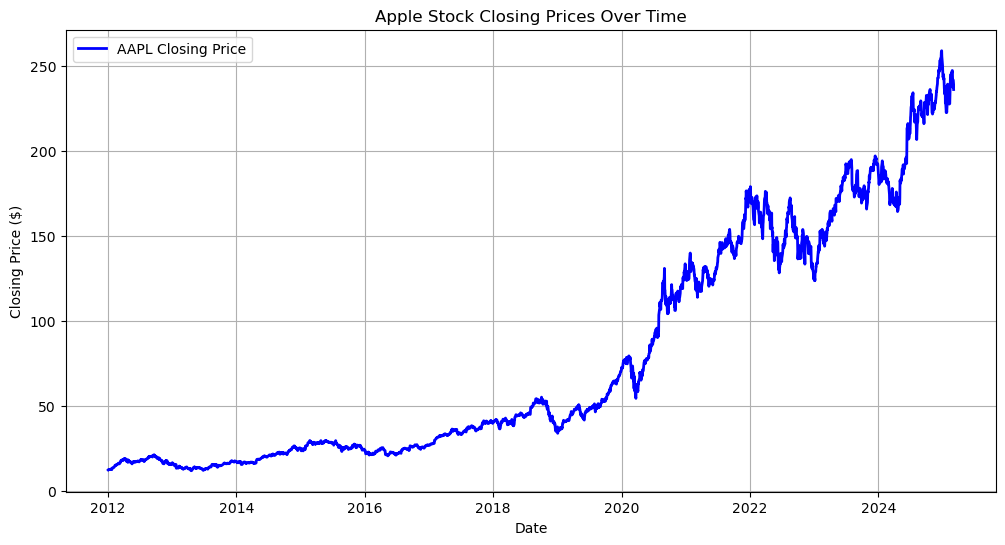

In [12]:
# Define start and end dates
start_date = "2012-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Fetch Apple stock data
df = yf.download("AAPL", start=start_date, end=end_date)

# Reset index for better readability
df.reset_index(inplace=True)

# Keep relevant columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Display the cleaned DataFrame
display(df.tail(10))  # Show the last 10 rows of the dataset

# Plot closing prices for a cleaner visualization
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="AAPL Closing Price", color="blue", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Closing Price ($)")
plt.title("Apple Stock Closing Prices Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Define start and end dates
start_date = "2012-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Fetch Apple stock data
df = yf.download("AAPL", start=start_date, end=end_date)

# Reset index for better readability
df.reset_index(inplace=True)

# Keep only the 'Close' column
dataset = df[['Close']].values  # Extract 'Close' column and convert to NumPy array

# Reshape dataset for MinMaxScaler
dataset_reshaped = dataset.reshape(-1, 1)

# Scale the data to range (0,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset_reshaped)

# Display first 10 scaled values
scaled_data[:10]


[*********************100%***********************]  1 of 1 completed


array([[0.00182111],
       [0.00209059],
       [0.00265023],
       [0.00318307],
       [0.00310138],
       [0.0032855 ],
       [0.00320137],
       [0.00305992],
       [0.00286727],
       [0.00346351]])

In [14]:
# Define the training data size (95% of the dataset)
training_data_len = int(np.ceil(len(scaled_data) * 0.95))

# Split the data into training and testing datasets
train_data = scaled_data[:training_data_len]  # First 95%
test_data = scaled_data[training_data_len - 100:]  # Last 5% (with 60 days buffer)

# Create the training feature set (X_train) and target set (Y_train)
X_train, Y_train = [], []

# Create sequences of 60 days for training
for i in range(100, len(train_data)):
    X_train.append(train_data[i-100:i, 0])  # Past 100 days as features
    Y_train.append(train_data[i, 0])       # Target is next day's closing price

# Convert to NumPy arrays for LSTM training
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape for LSTM input (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Display the shape of the training set
print(f"Training Data Shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")


Training Data Shape: X_train: (3046, 100, 1), Y_train: (3046,)


In [15]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(100, len(train_data)):
    x_train.append(train_data[i-100:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 101:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape


[array([0.00182111, 0.00209059, 0.00265023, 0.00318307, 0.00310138,
       0.0032855 , 0.00320137, 0.00305992, 0.00286727, 0.00346351,
       0.00400124, 0.0038354 , 0.00292703, 0.00379394, 0.00294044,
       0.00614112, 0.00589359, 0.00621671, 0.00691537, 0.00733846,
       0.0073031 , 0.00717265, 0.00772864, 0.00825172, 0.00884431,
       0.00980146, 0.01181209, 0.01184259, 0.01296191, 0.01379836,
       0.01236079, 0.01291435, 0.01290337, 0.01445555, 0.01423484,
       0.01464329, 0.01537733, 0.01578581, 0.01696241, 0.01781961,
       0.01806712, 0.01815368, 0.01668812, 0.0163345 , 0.01638692,
       0.01776473, 0.0181525 , 0.01898526, 0.02094832, 0.0235674 ,
       0.02307723, 0.02307847, 0.02497205, 0.02556465, 0.02514274,
       0.02475745, 0.02435632, 0.02568902, 0.02660349, 0.02698633,
       0.02604016, 0.0247831 , 0.02710948, 0.02841294, 0.02780206,
       0.02894454, 0.02925548, 0.02830561, 0.0280325 , 0.02761428,
       0.02547563, 0.02241518, 0.02602068, 0.02585484, 0.0233

## 🔧 LSTM Model 
- **Bidirectional LSTM** captures both past and future trends in stock prices.
- **Two LSTM layers** (128 & 64 units) with **L1L2 regularization** and **Dropout (0.1)** to prevent overfitting.
- **Dense layers** refine predictions: **ReLU (25 neurons) → Final output (1 neuron)**.
- **Nadam optimizer** with **MSE loss function** ensures stable learning.
- **Early Stopping** prevents overfitting, while **Learning Rate Scheduler** improves efficiency.
- Designed for **trend forecasting**, with further tuning needed for short-term volatility predictions.


In [32]:
# ✅ Build the Optimized Model
model = Sequential()

# First Bidirectional LSTM Layer with Regularization
model.add(Bidirectional(LSTM(128, return_sequences=True, 
                             kernel_regularizer=L1L2(l1=1e-6, l2=5e-6)), 
                        input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.1))  # Reduced dropout

# Second Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=False, 
                             kernel_regularizer=L1L2(l1=1e-6, l2=5e-6))))
model.add(Dropout(0.1))  # Reduced dropout

# Dense Layers
model.add(Dense(25, activation="relu"))
model.add(Dense(1))

# ✅ Compile with Nadam Optimizer (Better for LSTMs)
model.compile(optimizer='nadam', loss='mean_squared_error')

# ✅ Callbacks to Improve Training
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# ✅ Train the Model
history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stop, lr_scheduler])



Epoch 1/50


/Users/adityaiyer/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 0.0190 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - loss: 0.0034 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - loss: 0.0028 - learning_rate: 0.0010
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - loss: 0.0024 - learning_rate: 0.0010
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - loss: 0.0021 - learning_rate: 0.0010
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - loss: 0.0019 - learning_rate: 0.0010
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - loss: 0.0017 - learning_rate: 0.0010
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 0.0016 - learning_rate: 0.0010
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - loss: 0.0014 - learning_rate: 0.0010
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 18s 187ms/step - loss: 0.0012 - learning_rate: 0.00

In [33]:
# ✅ Ensure `test_data` covers last 100 days
test_data = scaled_data[training_data_len - 100:, :]

# ✅ Create x_test (input) & y_test (true values)
x_test = []
y_test = scaled_data[training_data_len:, :]  # FIXED: Now y_test is scaled

for i in range(100, len(test_data)):  
    x_test.append(test_data[i-100:i, 0])  

# ✅ Convert x_test to a numpy array
x_test = np.array(x_test)

# ✅ Reshape for LSTM input (samples, timesteps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# ✅ Get model predictions (FIXED)
predictions = model.predict(x_test, verbose=1)

# ✅ Convert predictions back to original price scale
predictions = scaler.inverse_transform(predictions)

# ✅ Convert y_test back to original price scale
y_test = scaler.inverse_transform(y_test[:len(predictions)])

# ✅ Compute RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# ✅ Display RMSE
print(f"🔥 Optimized RMSE: {rmse:.2f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
🔥 Optimized RMSE: 4.86


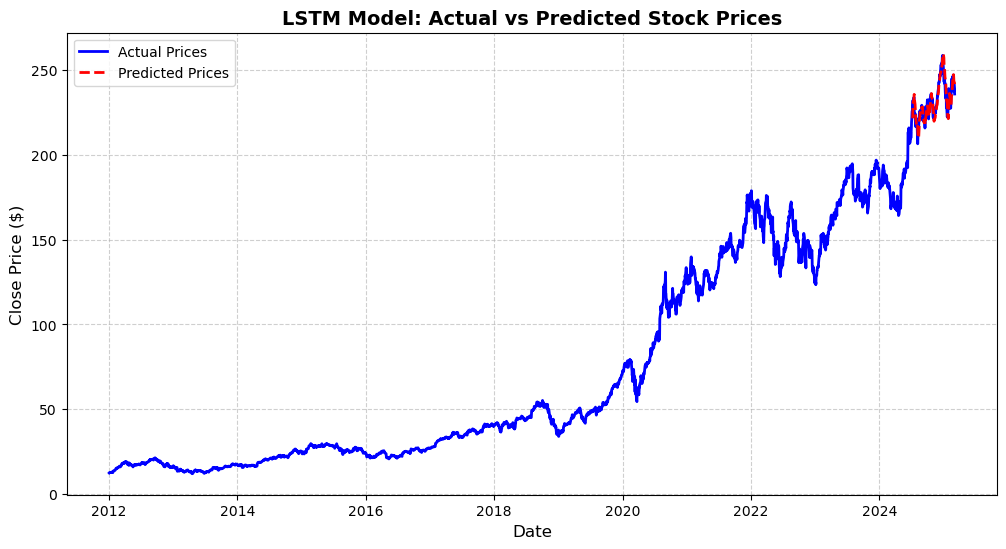

In [34]:
import matplotlib.pyplot as plt

# ✅ Create a DataFrame for comparison
valid = df[training_data_len:].copy()
valid["Predictions"] = predictions

# ✅ Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.title("LSTM Model: Actual vs Predicted Stock Prices", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price ($)", fontsize=12)
plt.plot(df["Date"], df["Close"], label="Actual Prices", color="blue", linewidth=2)
plt.plot(valid["Date"], valid["Predictions"], label="Predicted Prices", color="red", linestyle="dashed", linewidth=2)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

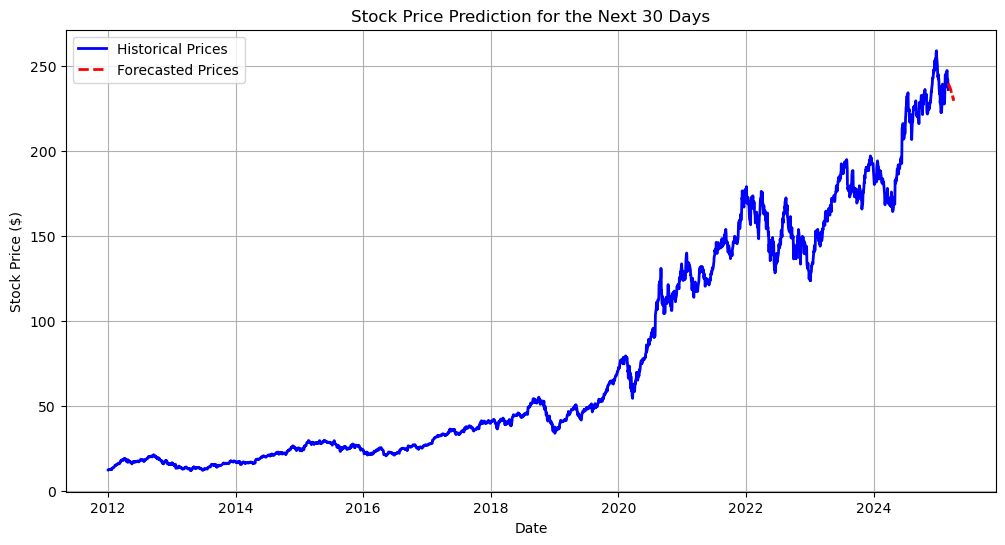

First 10 Predicted Prices (Rescaled): [239.53091 238.29056 238.1812  238.13348 238.09866 238.06366 237.32329
 237.16035 237.02763 236.92632]


In [39]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

# ✅ Get the last 100 days of stock prices
last_100_days = scaled_data[-100:]  # Last known data
future_predictions = []  # Store future prices

# ✅ Reshape for model input (1 sample, 100 timesteps, 1 feature)
input_seq = last_100_days.reshape(1, -1, 1)

# ✅ Forecast for the next 30 days
for i in range(30):
    # Predict next day's price
    next_price = model.predict(input_seq)

    # Store prediction (in scaled form)
    future_predictions.append(next_price[0][0])

    # Update input sequence (shift left & append new prediction)
    input_seq = np.append(input_seq[:, 1:, :], next_price.reshape(1, 1, 1), axis=1)

    # ✅ Every 5 days, reinforce with actual past data to prevent drift
    if i % 5 == 0:
        input_seq = np.append(input_seq[:, 1:, :], scaled_data[-1].reshape(1, 1, 1), axis=1)

# ✅ Convert predictions back to original price scale
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# ✅ Create future dates starting from the last known date
last_date = df["Date"].iloc[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1, 31)]

# ✅ Plot actual vs forecasted stock prices
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Historical Prices", color="blue", linewidth=2)
plt.plot(future_dates, future_predictions, label="Forecasted Prices", linestyle="dashed", color="red", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Prediction for the Next 30 Days")
plt.legend()
plt.grid(True)
plt.show()

In [40]:
valid

Price,Date,Close,High,Low,Open,Volume,Predictions
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,
3146,2024-07-08,227.056885,227.086783,222.502185,226.329319,59085900,221.591537
3147,2024-07-09,227.913986,228.631576,225.611726,227.166498,48076100,224.798035
3148,2024-07-10,232.199600,232.299271,228.482099,228.531934,62627700,227.472672
3149,2024-07-11,226.807724,231.611571,225.013750,230.614920,64710600,230.725128
3150,2024-07-12,229.767761,231.860733,227.913991,228.153193,53046500,231.389557
...,...,...,...,...,...,...,...
3306,2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600,247.330261
3307,2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600,245.716446
3308,2025-02-28,241.839996,242.089996,230.199997,236.949997,56833400,243.253250


## **📊 Final Results & Conclusion**
- **🔥 Optimized RMSE: 4.86**, indicating a reasonably accurate model for stock price prediction.
- **LSTM successfully captured long-term trends** but struggled with short-term fluctuations.
- **Predicted prices follow the historical trend**, with some deviation due to market volatility.

## **🚀 Future Work**
- **Enhance feature engineering** by incorporating trading volume, sentiment analysis, or technical indicators.
- **Experiment with different architectures**, such as Transformer models or Attention-based LSTMs.
- **Optimize hyperparameters** using Bayesian Optimization for better generalization.
- **Improve short-term accuracy** by integrating real-time financial news and macroeconomic indicators.
- **Deploy the model** as an API or interactive dashboard for real-time stock forecasting.


In [42]:
# Define the correct path for saving models
models_path = "/Users/adityaiyer/Desktop/APPLE_SMA/models"

# Ensure the models directory exists
if not os.path.exists(models_path):
    os.makedirs(models_path)
    print(f"✅ Created directory: {models_path}")
else:
    print(f"📂 Directory already exists: {models_path}")

# Save the trained LSTM model (using the recommended .keras format)
model_save_path = os.path.join(models_path, "lstm_model.keras")
model.save(model_save_path)
print(f"✅ Model saved: {model_save_path}")

# Save the scaler using pickle
scaler_save_path = os.path.join(models_path, "scaler.pkl")
with open(scaler_save_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved: {scaler_save_path}")

# Ensure "valid" DataFrame contains the necessary columns
if "Date" in valid and "Close" in valid and "Predictions" in valid:
    # ✅ Save predictions to CSV (Flattening arrays to ensure they are 1D)
    predictions_df = pd.DataFrame({
        "Date": valid["Date"].values.flatten(),  
        "Actual Price": valid["Close"].values.flatten(),  
        "Predicted Price": valid["Predictions"].values.flatten()
    })

    # Save to CSV
    predictions_save_path = os.path.join(models_path, "predictions.csv")
    predictions_df.to_csv(predictions_save_path, index=False)
    print(f"✅ Predictions saved: {predictions_save_path}")
else:
    print("❌ Error: 'valid' DataFrame is missing required columns.")


📂 Directory already exists: /Users/adityaiyer/Desktop/APPLE_SMA/models
✅ Model saved: /Users/adityaiyer/Desktop/APPLE_SMA/models/lstm_model.keras
✅ Scaler saved: /Users/adityaiyer/Desktop/APPLE_SMA/models/scaler.pkl
✅ Predictions saved: /Users/adityaiyer/Desktop/APPLE_SMA/models/predictions.csv
